In [1]:
import matplotlib.pylab as pl
%matplotlib inline
import numpy as np0
import cPickle as pickle
from scipy.stats import multivariate_normal as gaussian

In [2]:
data, labels = pickle.load(open('sanity-data', 'rb'))

In [3]:
import minpy.nn.model_builder as builder
from minpy.core import grad_and_loss as _gradient_loss
import sys
sys.path.append('../../nn/')
from facility import *
from solver_primitives import *

In [4]:
def probability_surface(model, N=256, lower=-10, upper=10, size=(5, 5)):
    X = np0.linspace(lower, upper, N)
    Y = np0.linspace(lower, upper, N)
    X, Y = np.meshgrid(X, Y)
    noise_X = np.vstack((flatten(X), flatten(Y))).T
    noise_Y = model.forward(noise_X, 'test')
    for i in range(4):
        noise_class = np.full((N * N,), i)
        noise_p = softmax_probability(noise_Y, noise_class)
        noise_p = noise_p.reshape(X.shape)
        pl.figure(figsize=size)
        c = pl.contour(to_np(X), to_np(Y), to_np(noise_p), 12)
        pl.clabel(c, fontsize=8)
        pl.title('probability surface (class %d)' % i)
        data_X, data_Y = data.T
        pl.plot(data_X, data_Y, 'bo')
        pl.gca().set_aspect('equal')

In [5]:
SHAPE = (64, 64, 64, 4)
network = builder.Sequential()
for shape in SHAPE[:-1]:
    network.append(builder.Affine(shape))
    network.append(builder.ReLU())
network.append(builder.Affine(SHAPE[-1]))
model = builder.Model(network, 'softmax', (2,))
initialize(model)
updater = Updater(model, 'sgd', {'learning_rate' : 0.3})

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


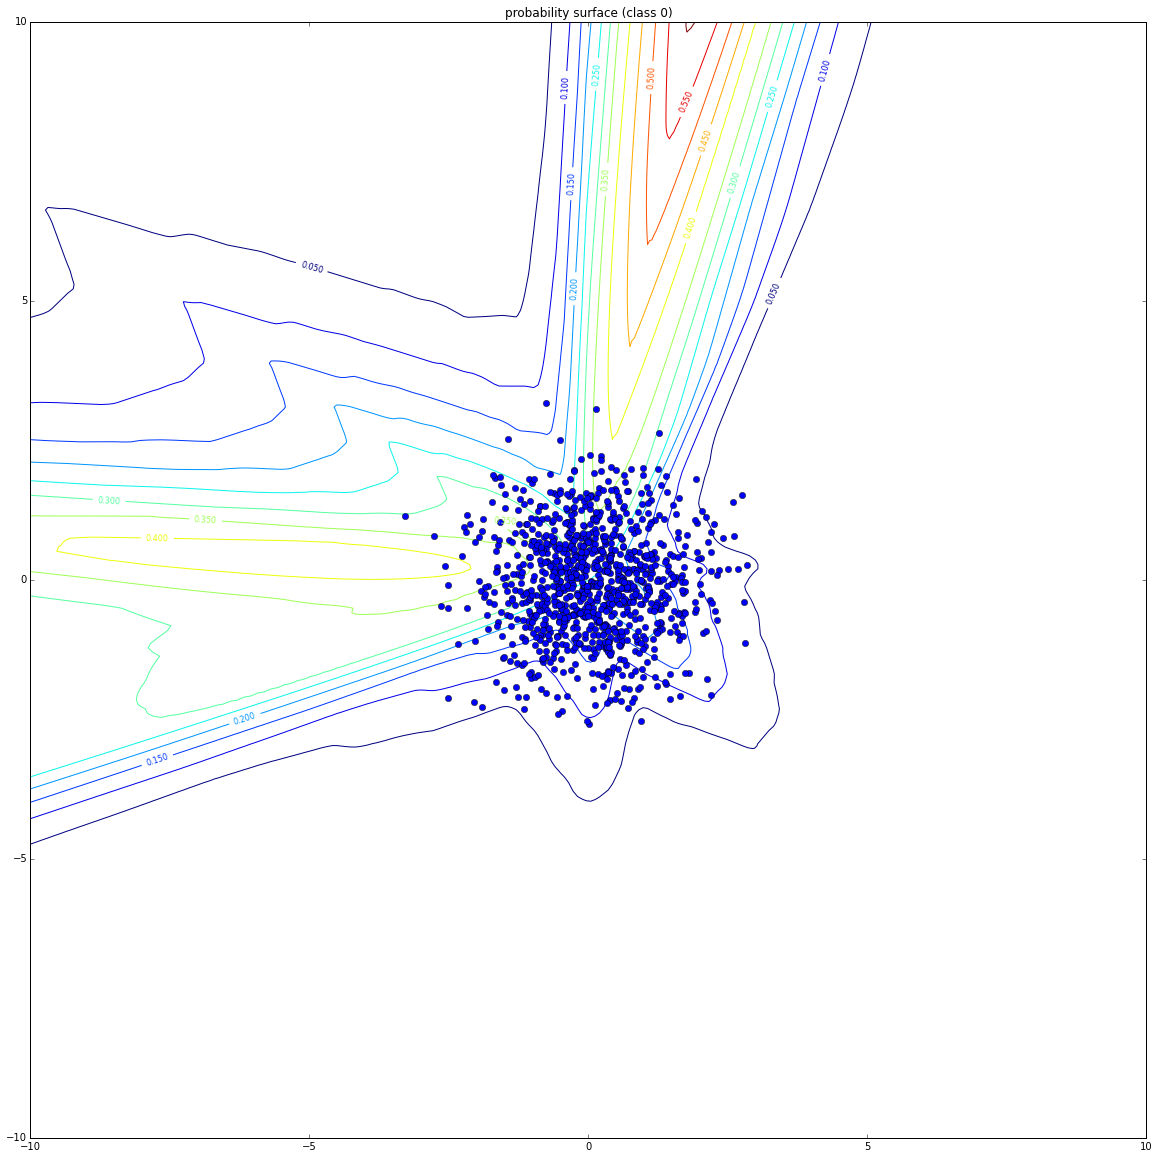

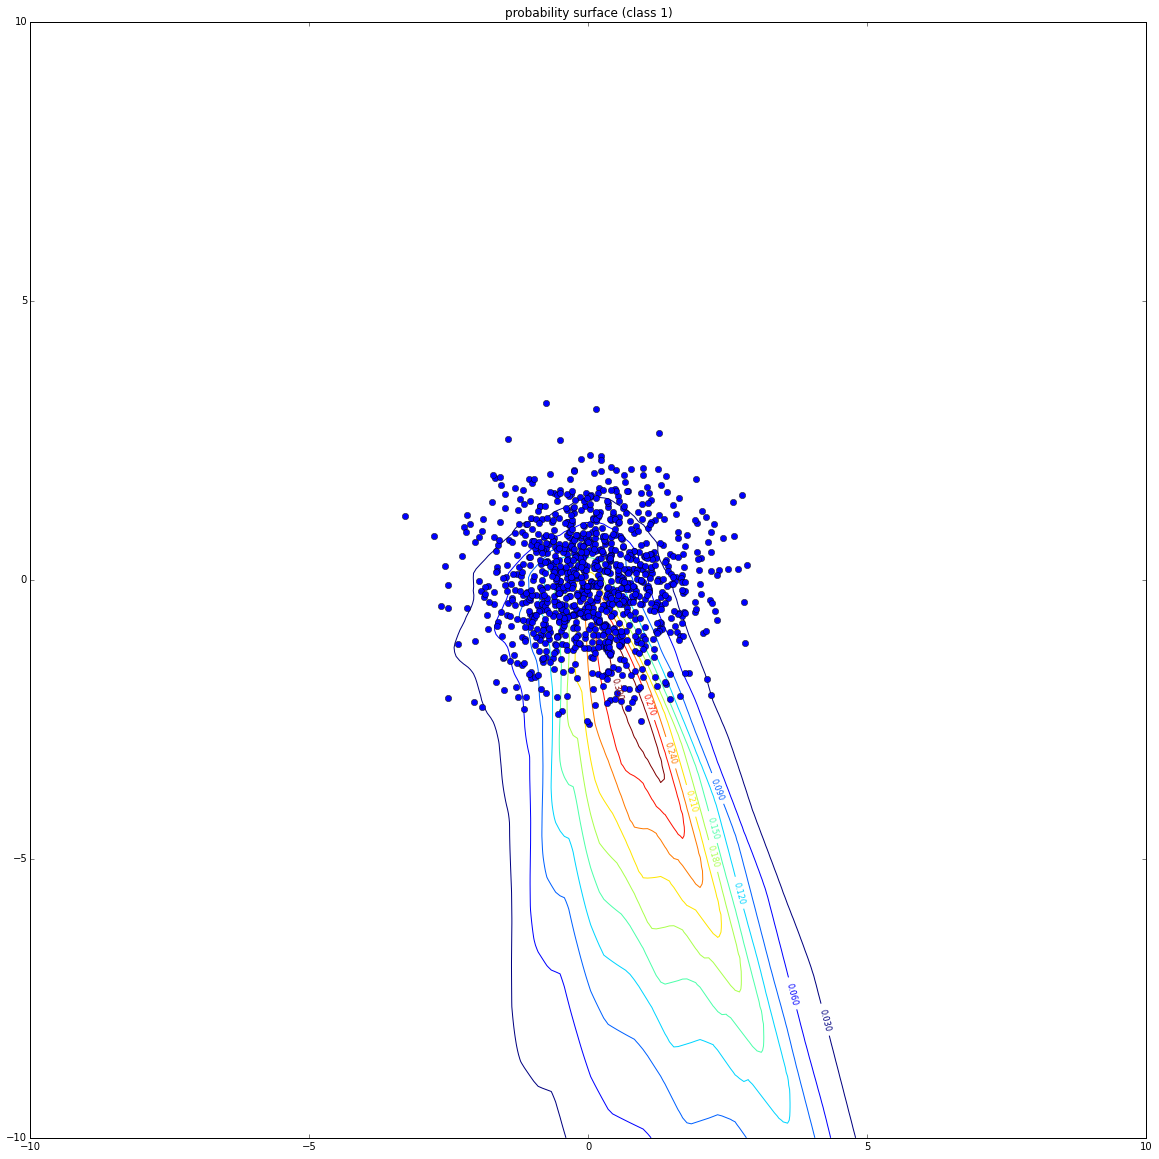

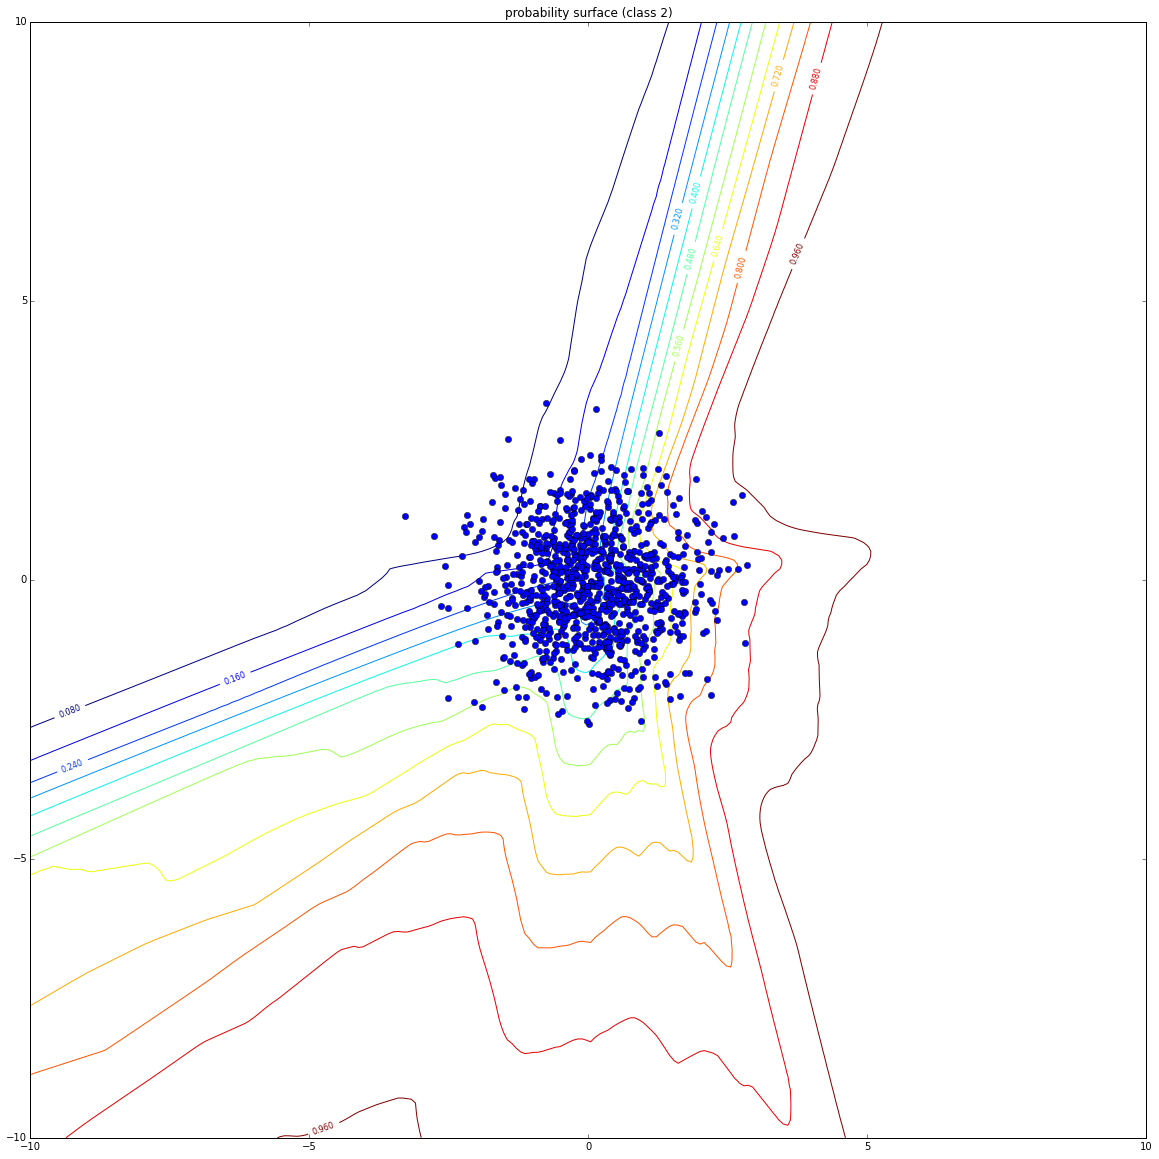

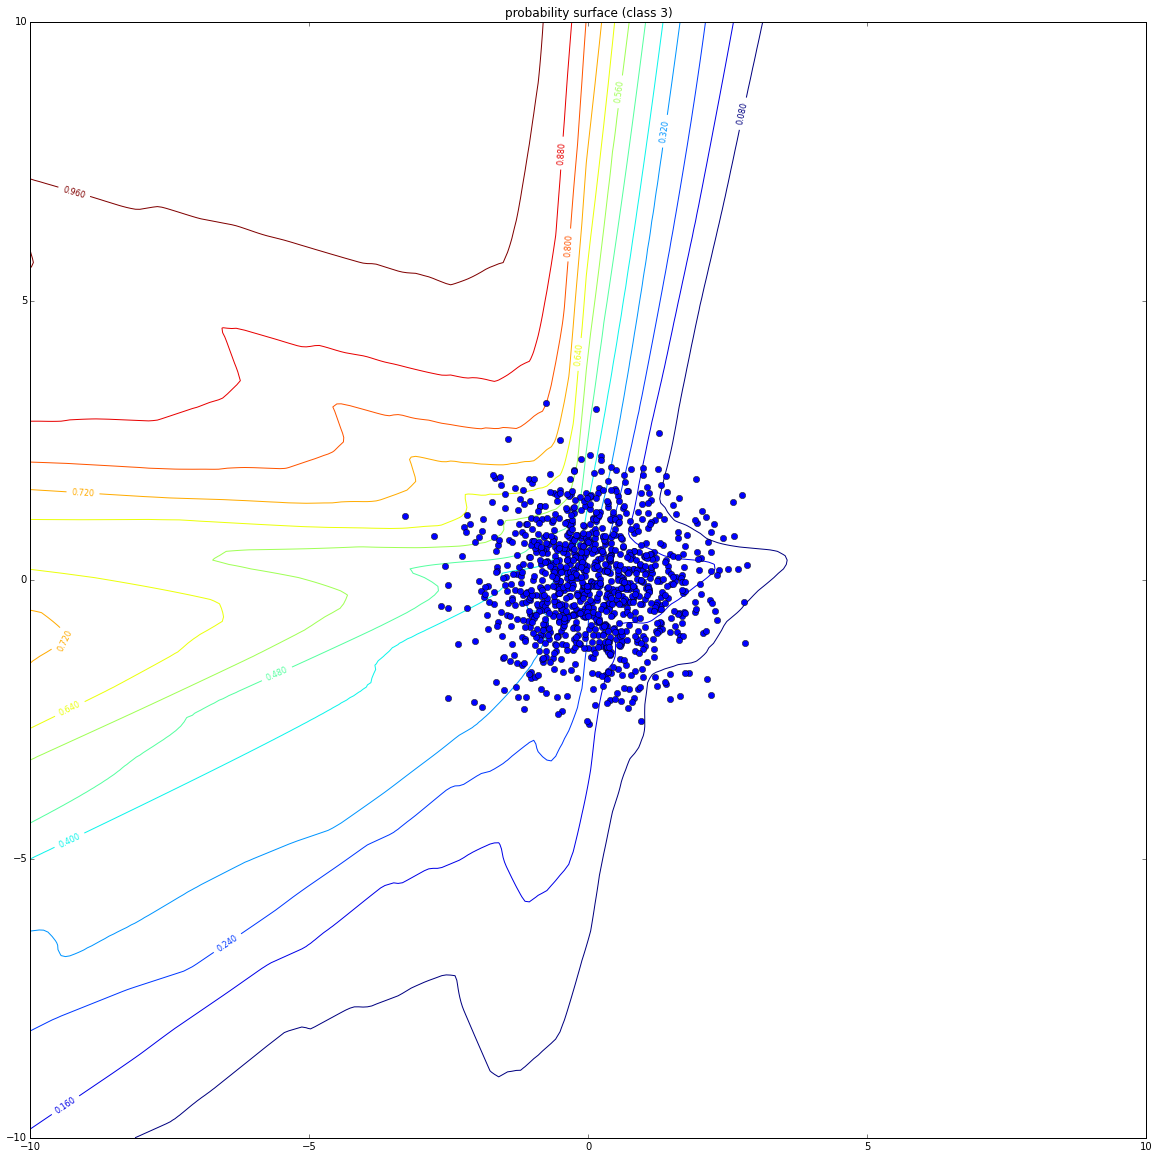

In [6]:
probability_surface(model, size=(20, 20))

In [ ]:
sample = lambda N, D : np.random.uniform(-10, 10, (N, D))

@np_wrapper
def pdf(X, mean=0, std=1):
    N, D = X.shape
    mean = np0.full((D,), mean)
    covariance = np0.eye(D) * std
    return gaussian.pdf(X.tolist(), mean.tolist(), covariance.tolist())

def noisy_gradient_loss(model, X, Y, gamma, K, N_CLASSES=4):
    N, D = X.shape
    noisy_X = sample(K, D)
    p_noisy_X = pdf(noisy_X)
    def _loss_function(*args):
        normal_loss = model.loss(model.forward(X, 'train'), Y)
        noisy_output = model.forward(noisy_X, 'train')
        noisy_output -= np.max(noisy_output, axis=1).reshape((K, 1))
        noisy_output = np.exp(noisy_output)
        model_p_noisy_X = noisy_output / np.sum(noisy_output, axis=1).reshape((K, 1))
        kl = KL(1.0 / N_CLASSES, model_p_noisy_X)
        noisy_loss = gamma * np.sum(kl) / float(K)
#         print noisy_loss
        return normal_loss + noisy_loss
    gl = _gradient_loss(_loss_function, range(len(model.params)))
    parameters = list(model.params.values())
    return gl(*parameters)

In [ ]:
ITERATIONS = 3000
LOGGING_INTERVAL = 100
loss_history = []
for i in range(ITERATIONS):
    gradients, loss = noisy_gradient_loss(model, data, labels, 0.1, 3)
    updater.update(gradients)
    loss = to_float(loss)
    loss_history.append(loss)
#     if (i + 1) % LOGGING_INTERVAL == 0:
#         print 'iteration', i, 'loss', loss
pl.plot(range(ITERATIONS), loss_history)
pl.title('loss')

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full((2,), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [ ]:
probability_surface(model, size=(20, 20))